# Ensemble mean anomaly ACCESS-S2 forecasts for wet 2022 events

In [1]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = '02:00:00'
cores = 10
memory = str(4 * cores)
memory = memory + 'GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=['-q normal',
                                           '-P w42',
                                           '-l ncpus='+str(cores),
                                           '-l mem='+str(memory),
                                           '-l storage=gdata/w42+gdata/rt52+gdata/ux62'],
                     local_directory='$TMPDIR',
                     job_directives_skip=["select"])

In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.41:35383,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
# client.close()
# cluster.close()

In [13]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import climpred
import cftime

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy
cartopy.config['pre_existing_data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data'
cartopy.config['data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data'

In [7]:
def get_plot_params():
    """
    Get the plotting parameters used for figures
    """
    FONT_SIZE = 7
    COASTLINES_LW = 0.5
    LINEWIDTH = 1.3
    PATHEFFECT_LW_ADD = LINEWIDTH * 1.8

    return {'lines.linewidth': LINEWIDTH,
            'hatch.linewidth': 0.5,
            'font.size': FONT_SIZE,
            'legend.fontsize' : FONT_SIZE - 1,
            'legend.columnspacing': 0.7,
            'legend.labelspacing' : 0.03,
            'legend.handlelength' : 1.,
            'axes.linewidth': 0.5}

plt_params = get_plot_params()

# Load hindcast climatology

This climatology is lead time- and calendar month of initialisation date-dependent

In [8]:
hcast_clim = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/access-s2/pr_hindcast_month_clim_1981-2018.zarr',
    consolidated=True
)

In [9]:
hcast_clim = hcast_clim['pr']

In [18]:
hcast_clim = hcast_clim.rename({'lead_time': 'lead'})

In [19]:
hcast_clim

<xarray.DataArray 'pr' (month: 12, lead: 62, lat: 63, lon: 60)>
dask.array<open_dataset-b8f02f699b263bd184e31796bd4c3a2bpr, shape=(12, 62, 63, 60), dtype=float32, chunksize=(12, 62, 63, 60), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -44.72 -44.17 -43.61 -43.06 ... -11.39 -10.83 -10.28
  * lead     (lead) int64 0 1 2 3 4 5 6 7 8 9 ... 52 53 54 55 56 57 58 59 60 61
  * lon      (lon) float32 110.4 111.2 112.1 112.9 ... 157.1 157.9 158.8 159.6
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

# Load forecast data

In [11]:
fc_path = '/g/data/w42/lz3062/s2_fcst/'

Get initialisation dates. We use 3 initialisation dates per event, on consecutive days.

In [12]:
init_dates = sorted(os.listdir(fc_path)) # Initialisation dates. Note directory structure is different to hindcast data.

Obtain dataset of all forecasts, with dimensions for ensemble member (member; 1-33), lat, lon, lead time (lead), forecast initialisation date (init).

In [14]:
ds_list = []
for init in init_dates: # loop through each init date
    members = sorted(os.listdir(fc_path + init))
    files = []
    for member, file in enumerate(members):
        fcast = xr.open_mfdataset(fc_path + init + '/' + file)
        fcast = fcast.expand_dims({'member': [member + 1]}) # give this dataset the ensemble dimension
        files.append(fcast)
        
    fcast_ens = xr.concat(files, dim='member') # concatenate over all members
    # fcast_ens = fcast_ens.rename({'time': 'target_date'}) # rename time to target_date
    # fcast_ens = fcast_ens.expand_dims({'init': [fcast_ens['time'].values[0]]}) # assign new init date dimension
    init0 = pd.to_datetime(fcast_ens['time'].values[0])
    cf_init = cftime.datetime(init0.year, init0.month, init0.day)
    fcast_ens = fcast_ens.expand_dims({'init': [cf_init]}) # assign new init date dimension
    
    fcast_ens = fcast_ens.rename({'time': 'lead'}) # rename time to target_date
    fcast_ens = fcast_ens.assign_coords({'lead': range(len(fcast_ens['lead']))})
    
    ds_list.append(fcast_ens)
    
fcast_ds = xr.concat(ds_list, dim='init') # concat over all init dates

In [16]:
fcast_ds = fcast_ds['pr']

Select Australian region

In [15]:
fcast_ds = fcast_ds.sel(
    lon=slice(110, 160),
    lat=slice(-45, -10)
)

In [17]:
fcast_ds

<xarray.DataArray 'pr' (init: 18, member: 33, lead: 42, lat: 63, lon: 60)>
dask.array<getitem, shape=(18, 33, 42, 63, 60), dtype=float32, chunksize=(1, 1, 42, 63, 60), chunktype=numpy.ndarray>
Coordinates:
  * init     (init) object 2022-02-22 00:00:00 ... 2022-10-01 00:00:00
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 25 26 27 28 29 30 31 32 33
  * lat      (lat) float32 -44.72 -44.17 -43.61 -43.06 ... -11.39 -10.83 -10.28
  * lon      (lon) float32 110.4 111.2 112.1 112.9 ... 157.1 157.9 158.8 159.6
  * lead     (lead) int64 0 1 2 3 4 5 6 7 8 9 ... 32 33 34 35 36 37 38 39 40 41
Attributes:
    stash_item:     216
    stash_model:    1
    lookup_source:  defaults (cdunifpp V0.14pre1)
    long_name:      TOTAL PRECIPITATION RATE     KG/M2/S
    cell_methods:   time: mean
    units:          kg m-2 s-1
    stash_section:  5
    standard_name:  precipitation_flux

# Calculate anomalies

In [21]:
anoms = fcast_ds.groupby('init.month') - hcast_clim

In [22]:
anoms["lead"].attrs["units"] = "days" # Set units of lead time

Add a valid_time coordinate (target date)

In [23]:
anoms = climpred.utils.add_time_from_init_lead(anoms)

# Set forecast target periods

In [24]:
# format is {init_date: [target_start_date, target_end_date]}
feb_target_lead0 = {'2022-02-24': [cftime.datetime(2022, 2, 24), cftime.datetime(2022, 3, 2)]}
mar_target_lead0 = {'2022-03-03': [cftime.datetime(2022, 3, 3), cftime.datetime(2022, 3, 9)]}

jul_target_lead1 = {'2022-06-23': [cftime.datetime(2022, 6, 30), cftime.datetime(2022, 7, 6)]}
jul_target_lead0 = {'2022-06-30': [cftime.datetime(2022, 6, 30), cftime.datetime(2022, 7, 6)]}

oct_target_lead1 = {'2022-09-01': [cftime.datetime(2022, 10, 1), cftime.datetime(2022, 10, 31)]}
oct_target_lead0 = {'2022-10-01': [cftime.datetime(2022, 10, 1), cftime.datetime(2022, 10, 31)]}

# Example: March

In [25]:
init = '2022-03-03'
t1 = mar_target_lead0[init][0]
t2 = mar_target_lead0[init][1]

### Make sure you select the correct inits

In [26]:
# We use the init plus the inits from the two days prior
start = pd.to_datetime(init) - pd.DateOffset(days=2)
start = cftime.datetime(start.year, start.month, start.day)
inits = xr.cftime_range(start=start, end=init, freq="1D")

In [27]:
fcast1 = anoms.sel(init=inits)

In [28]:
fcast1 = fcast1.where(
    (anoms.valid_time >= t1) &
    (anoms.valid_time <= t2)
)

Visualise this to see we have the right period:

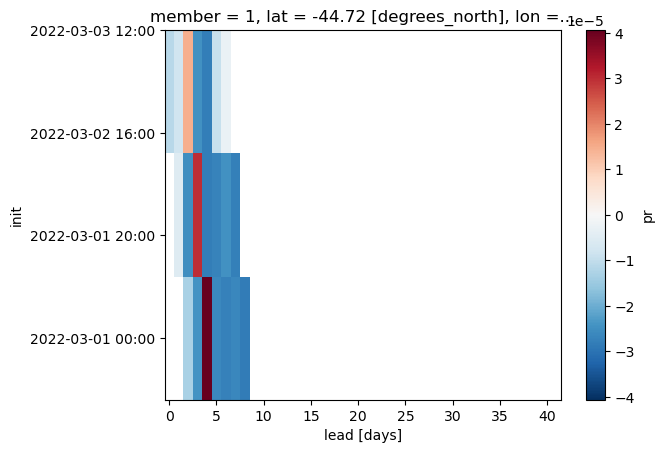

In [29]:
fcast1.isel(member=0, lat=0, lon=0, init=range(3)).plot()

Mean rainfall forecast for 03/03 through 09/03, initialised on 03/03.
Ensemble average of 99 members from 3 initialisation dates.

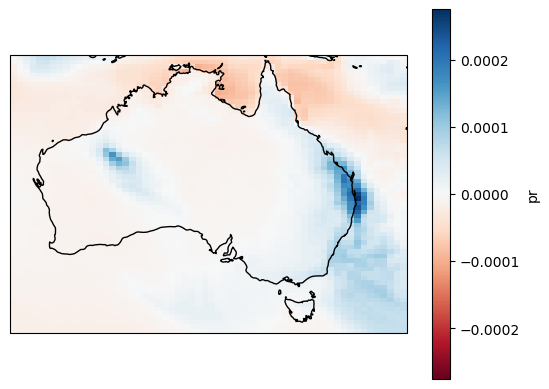

In [30]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
fcast1.mean(['init', 'lead', 'member']).plot(ax=ax, cmap='RdBu')
ax.coastlines(color='black')

# Plot data for all 6 cases

In [31]:
plot_data = {
    '24/02 - 02/03 (Lead 0)': None,
    '03/03 - 09/03 (Lead 0)': None,
    '30/06 - 06/07 (Lead 1)': None,
    '30/06 - 06/07 (Lead 0)': None,
    '01/10 - 31/10 (Lead 1)': None,
    '01/10 - 31/10 (Lead 0)': None
}

In [ ]:
# format is {init_date: [target_start_date, target_end_date]}
feb_target_lead0 = {'2022-02-24': [cftime.datetime(2022, 2, 24), cftime.datetime(2022, 3, 2)]}
mar_target_lead0 = {'2022-03-03': [cftime.datetime(2022, 3, 3), cftime.datetime(2022, 3, 9)]}

jul_target_lead1 = {'2022-06-23': [cftime.datetime(2022, 6, 30), cftime.datetime(2022, 7, 6)]}
jul_target_lead0 = {'2022-06-30': [cftime.datetime(2022, 6, 30), cftime.datetime(2022, 7, 6)]}

oct_target_lead1 = {'2022-09-01': [cftime.datetime(2022, 10, 1), cftime.datetime(2022, 10, 31)]}
oct_target_lead0 = {'2022-10-01': [cftime.datetime(2022, 10, 1), cftime.datetime(2022, 10, 31)]}

In [36]:
list(feb_target_lead0.keys())

['2022-02-24']

In [42]:
for key, event in zip(
    list(plot_data.keys()),
    [
        feb_target_lead0,
        mar_target_lead0,
        jul_target_lead1,
        jul_target_lead0,
        oct_target_lead1,
        oct_target_lead0
    ]
):
    init = list(event.keys())[0] # Initialisation date
    t1 = event[init][0] # First date of target window
    t2 = event[init][1] # Last date of target window
    
    # We use the init plus the inits from the two days prior
    start = pd.to_datetime(init) - pd.DateOffset(days=2)
    start = cftime.datetime(start.year, start.month, start.day)
    inits = xr.cftime_range(start=start, end=init, freq="1D")
    
    # Select these inits
    fcast = anoms.sel(init=inits)
    
    # Mask out dates not in the target window
    fcast = fcast.where(
        (anoms.valid_time >= t1) &
        (anoms.valid_time <= t2)
    )
    
    # Compute mean over inits, lead times and member
    # This gives the 99-member ensemble mean forecast for the mean rainfall over the target window
    fcast = fcast.mean(['init', 'lead', 'member'])
    
    # Convert precipitation flux (kg m-2 s-1) to mm day-1
    fcast = fcast * 24 * 60 * 60
    
    # Place in dict and compute
    plot_data[key] = fcast.compute()

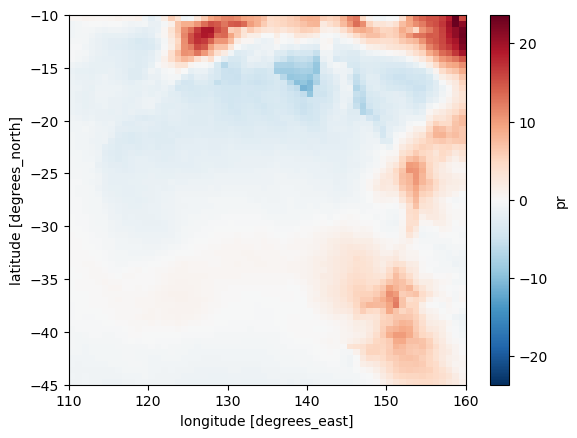

In [43]:
plot_data['24/02 - 02/03 (Lead 0)'].plot()

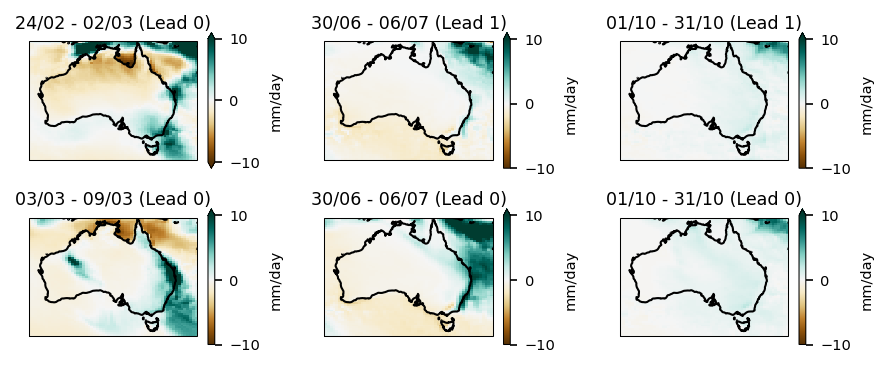

In [59]:
with plt.rc_context(plt_params):
    fig, ax = plt.subplots(2, 3, figsize=(6.9, 2.7), dpi=150, subplot_kw={'projection': ccrs.PlateCarree()})
    
    for axi, event_name, da in zip(
        [0, 3, 1, 4, 2, 5],
        list(plot_data.keys()),
        list(plot_data.values())
    ):
        axis = ax.flatten()[axi]
        
        axis.coastlines()
        da.plot(ax=axis, cmap='BrBG', vmin=-10, vmax=10,
               cbar_kwargs={'label': 'mm/day'})
        
        axis.set_title(event_name)

    plt.subplots_adjust(hspace=0.3, wspace=0.4)

# Close cluster

In [150]:
client.close()
cluster.close()